# Homework 07

### Preparation...

Run this code from the lecture to be ready for the exercises below!

In [1]:
import glob
import os.path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn import datasets, linear_model, ensemble, neural_network
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from pathlib import Path

In [2]:
CONFIG_FILE = '../entsoe-data.config'

if not os.path.exists(CONFIG_FILE):
    download_dir = input('Path to ENTSO-E data folder: ')
    if not os.path.isdir(download_dir):
        raise RuntimeError(f'Invalid download_dir, please run cell again: {download_dir}')
    with open(CONFIG_FILE, 'w') as f:
        f.write(download_dir)
else:
    with open(CONFIG_FILE) as f:
        download_dir = f.read()
        
# Clear the output after this cell if you want to aovid having your path in the notebook (or execute it twice)!

In [3]:
def read_single_csv_entso_e(file):
    return pd.read_csv(file, sep='\t', encoding='utf-16', parse_dates=["DateTime"])


def load_complete_entso_e_data(directory):
    pattern = Path(directory) / '*.csv'
    files = glob.glob(str(pattern))

    if not files:
        raise ValueError(f"No files found when searching in {pattern}, wrong directory?")
    
    print(f'Concatenating {len(files)} csv files...')

    each_csv_file = [read_single_csv_entso_e(file) for file in files]
    data = pd.concat(each_csv_file, ignore_index=True)

    data = data.sort_values(by=["AreaName", "DateTime"])
    data = data.set_index("DateTime")

    print("Loading done.")

    return data


power_demand = load_complete_entso_e_data(download_dir)

Concatenating 68 csv files...
Loading done.


In [4]:
def get_hourly_country_data(data, country):
    ret_data = data[data["AreaName"] == country].interpolate()
    #ret_data = ret_data.set_index("DateTime")
    ret_data = ret_data.resample("1h").mean().interpolate()
    return ret_data

power_demand_at_hourly = get_hourly_country_data(power_demand, "Austria")["2015-01-01":"2019-12-31"]

## Exercise 1

Explain the following terms:

**Input feature:** < your explanation goes here >

**Output feature:** < your explanation goes here >

**Fit a function to data:** < your explanation goes here >

**Training data:** < your explanation goes here >

**Test data:** < your explanation goes here >


    

## Exercise 2

In lecture07 we created a plot of the ratio of actual load and predicted load for Austria step by step (Exercise 04). Now put all of this together in one function which takes one parameter `country` as input and calculates and plots the figure of Exercise 04 for this country! The model should be trained on 2015-2019 data and then you should predict for 2020 and compare it to observations. Also do a training/test split and print the R2 for both datasets.

Apply the function to the following countries and show the results in one plot: Austria, Germany, Switzerland, Italy, Spain, Sweden, United Kingdom.

(1) Print the country name. Get the data for the specific country using ```get_hourly_country_data``` from the lecture and extract two periods, i.e 2015-2019 and 2020 in two separate dataframes.

(2) Define X (the input features, i.e. the indicators for time) and Y (i.e. the output feature, the electricity load). Observe that for training, we use the period 2015-2019.

(3) Do a train/test split

(4) Fit the input features to the output feature using a ```RandomForestRegressor```

(5) Predict the output with the training data and the test data and compute the R^2 for both!

(6) Print the R^2.

(7) Create a new variable ```X_2020``` which contains the input features for the year 2020.

(8) Predict with your model the load for 2020.

(9) Assign your prediction back to the dataframe in a new column and calculate the monthly mean for prediction and for observed load. You might need to copy the dataframe first by doing something like `power_demand_hourly = power_demand_hourly.copy()` (otherwise it might be just a slice of the complete time range and then you can't add a column for some rows only).

(10) Plot the ratio of load and prediction. With ```label=country```, you can add a label to your plot for making a legend.

(11) Execute the function for the following countries: Austria, Germany, Switzerland, Italy, Spain, Sweden, United Kingdom.

(12) After calling the functions, use ```plt.legend()``` to show a legend.

In [11]:
def power_demand_ration(country):
    print(country)
    print("Estimating load")
    
    power_demand_hrl_2019 = get_hourly_country_data(power_demand, country)["2015-01-01":"2019-12-31"]
    power_demand_hrl_2020 = get_hourly_country_data(power_demand, country)["2020-01-01":]
    
    X_2019 = np.array([power_demand_hrl_2019.index.dayofyear.values,
     power_demand_hrl_2019.index.weekday.values,
     power_demand_hrl_2019.index.hour.values]).T
    
    Y_2019 = power_demand_hrl_2019["TotalLoadValue"].values
    
    X_training, X_test, Y_training, Y_test = train_test_split(X_2019, Y_2019, test_size=0.2)
    
    forest_model = ensemble.RandomForestRegressor()

    # Train the model using the training sets
    forest_model.fit(X_training, Y_training)

    prediction_training = forest_model.predict(X_training)
    prediction_test = forest_model.predict(X_test)
    
    print("R² score for training data:",r2_score(Y_training,prediction_training))
    print("R² score for test data:",r2_score(Y_test,prediction_test))
    
    X_2020 = np.array([power_demand_hrl_2020.index.dayofyear.values,
     power_demand_hrl_2020.index.weekday.values,
     power_demand_hrl_2020.index.hour.values]).T
    
    prediction_2020 = forest_model.predict(X_2020)
    
    power_demand_hrl_2020 = power_demand_hrl_2020.copy()
    power_demand_hrl_2020["Predicted_values"] = prediction_2020
    
    power_demand_monthly_2020 = power_demand_hrl_2020.resample('1m').mean()

    proportion = power_demand_monthly_2020["Predicted_values"] / power_demand_monthly_2020["TotalLoadValue"]

    x = ["Jan","Feb","March","April","May"]
    plt.plot(x,proportion,'o',label=country)
    plt.xlabel("Month")
    plt.ylabel("Ratio Predicted / Actual Load 2020")

Austria
Estimating load
R² score for training data: 0.9917670177186707
R² score for test data: 0.9429233115013073
Germany
Estimating load
R² score for training data: 0.9938902593671314
R² score for test data: 0.9544874379478638
Switzerland
Estimating load
R² score for training data: 0.9824439583701539
R² score for test data: 0.8817617272454447
Italy
Estimating load
R² score for training data: 0.9959636902048725
R² score for test data: 0.9728683884721274
Spain
Estimating load
R² score for training data: 0.9925235434709694
R² score for test data: 0.9465070411622338
Sweden
Estimating load
R² score for training data: 0.992371339061619
R² score for test data: 0.9445419822319977
United Kingdom
Estimating load
R² score for training data: 0.9776867502394195
R² score for test data: 0.8372306988814889


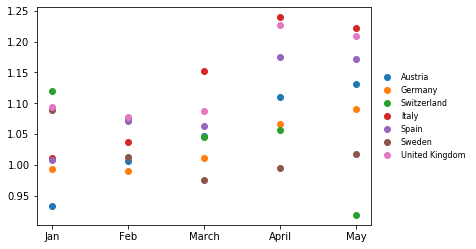

In [15]:
power_demand_ration("Austria")
power_demand_ration("Germany")
power_demand_ration("Switzerland")
power_demand_ration("Italy")
power_demand_ration("Spain")
power_demand_ration("Sweden")
power_demand_ration("United Kingdom")
plt.legend(
    frameon=False,
    loc='center left',
    bbox_to_anchor=(1.0,0.5),
    ncol=1,
    fontsize=8
    )

## Exercise 3
Answer the following questions:

(1) Which country had the strongest decline in electricity consumption?

Italy

(2) For which country does the fit work best?

highest R² for test data: Italy

(3) Where is the difference of R2 between training data and test data the largest? What does that mean?

largest difference: UK
This means that the developed model does work least well in the UK compared to other countries, both in terms of absolute R² (lowest for test data) and in terms of the difference between training and test data.

(4) Look into the data of the country with the largest difference in the R2 of the training and the test data. Can you explain what is happening there? Might this effect our model?

This difference might be due to missing data or a coarser resolution from 2017-2018 for which was interpolated when calling the function get_hourly_country_data()

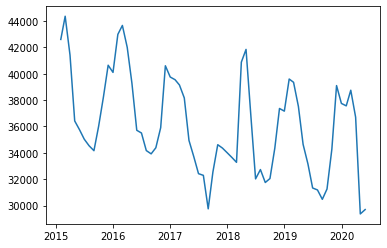

In [51]:
power_demand_hrl_UK = get_hourly_country_data(power_demand, "United Kingdom")
UK_month_mean = power_demand_hrl_UK.resample('1m').mean()

plt.plot(UK_month_mean["TotalLoadValue"])

UK_day_mean = power_demand_hrl_UK.resample('1d').mean()

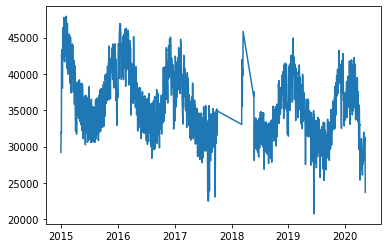

In [52]:
plt.plot(UK_day_mean["TotalLoadValue"])

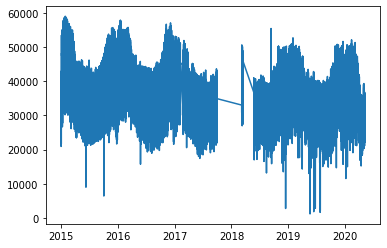

In [58]:
plt.plot(power_demand_hrl_UK["TotalLoadValue"])

In [67]:
def get_country_data(data, country):
    ret_data = data[data["AreaName"] == country]
    #ret_data = ret_data.set_index("DateTime") #index = unique identifier of row
    return ret_data


power_demand_uk = get_country_data(power_demand, "United Kingdom")

In [75]:
power_d_uk_1718 = power_demand_uk["2017-08-01":"2018-03-01"]
power_d_uk_1718.head(n=10)

,Year,Month,Day,ResolutionCode,areacode,AreaTypeCode,AreaName,MapCode,TotalLoadValue,UpdateTime
DateTime,,,,,,,,,,
2017-08-01 01:00:00,2017,8,1,PT30M,GB,CTY,United Kingdom,GB,23400.0,2018-05-22 20:31:16
2017-08-01 01:30:00,2017,8,1,PT30M,GB,CTY,United Kingdom,GB,22944.0,2018-05-22 20:31:16
2017-08-05 01:00:00,2017,8,5,PT30M,GB,CTY,United Kingdom,GB,22629.0,2018-05-22 21:31:13
2017-08-05 01:30:00,2017,8,5,PT30M,GB,CTY,United Kingdom,GB,22143.0,2018-05-22 21:31:13
2017-08-08 02:00:00,2017,8,8,PT30M,GB,CTY,United Kingdom,GB,22998.0,2018-05-22 22:01:26
2017-08-08 02:30:00,2017,8,8,PT30M,GB,CTY,United Kingdom,GB,23000.0,2018-05-22 22:01:26
2017-08-08 16:00:00,2017,8,8,PT30M,GB,CTY,United Kingdom,GB,39764.0,2018-05-22 22:16:06
2017-08-08 16:30:00,2017,8,8,PT30M,GB,CTY,United Kingdom,GB,39595.0,2018-05-22 22:16:06
2017-08-12 04:00:00,2017,8,12,PT30M,GB,CTY,United Kingdom,GB,22090.0,2018-05-22 23:01:15


## Exercise 4

The difference between model prediction and actual observation may help understanding how people behaved during the lockdown. In this exercise, you should come up with your own hypothesis of how people behaved and how this affected power consumption. You may, e.g., look into demand on different weekdays or in different hours. Once you have a hypothesis and a theory, why this hypothesis may be valid, test it with the model: is your hypothesis covered by what you observe in the load data?

### My hypothesis: 
less power demand on weekdays (i.e. Monday-Friday) because of less work, i.e. more unemployed or "Kurzarbeit", more home office, less public transport,fewer open shops etc.

In [89]:
#Hypothesis: power demand on weekdays after lookdown is smaller compared to before
#I use a simple t-test with average power demand per weekday; with a monthly dummy 

power_demand_hrl_AT = get_hourly_country_data(power_demand, "Austria")
AT_day_mean =  power_demand_hrl_AT.resample('1d').mean()

AT_day_mean.head(n=20)
#plt.plot(AT_day_mean["TotalLoadValue"])

,Year,Month,Day,TotalLoadValue
DateTime,,,,
2014-12-01,2014,12,1,6450.300000
2014-12-02,2014,12,2,7584.245833
2014-12-03,2014,12,3,7610.300000
2014-12-04,2014,12,4,7832.933333
2014-12-05,2014,12,5,7512.570833
2014-12-06,2014,12,6,6751.533333
2014-12-07,2014,12,7,6911.800000
2014-12-08,2014,12,8,6846.691667
2014-12-09,2014,12,9,7470.820833


In [199]:


##now only select weekdays and compare March-May of previous years with March-May 2020
power_demand_weekday_AT = AT_day_mean.loc[AT_day_mean.index.weekday < 5,]
print(power_demand_weekday_AT.head(n=10))

#selecting lockdown months in years 2015-2019
l = [3,4,5]
#power_demand_weekday_AT_preLockdown = power_demand_weekday_AT.loc[power_demand_weekday_AT.index.month == any(l),]
power_demand_weekday_AT_preLockdown = power_demand_weekday_AT[power_demand_weekday_AT.index.month.isin(l)]["2014-12-01":"2019-12-31"]
print(power_demand_weekday_AT_preLockdown.head(n=10))

power_demand_weekday_AT_postLockdown = power_demand_weekday_AT[power_demand_weekday_AT.index.month.isin(l)]["2020-01-01":"2020-12-31"]
power_demand_weekday_AT_postLockdown.head(n=10)

#t-test:
from scipy import stats
stats.ttest_ind(power_demand_weekday_AT_preLockdown["TotalLoadValue"],power_demand_weekday_AT_postLockdown["TotalLoadValue"], equal_var = False)

            Year  Month  Day  TotalLoadValue
DateTime                                    
2014-12-01  2014     12    1     6450.300000
2014-12-02  2014     12    2     7584.245833
2014-12-03  2014     12    3     7610.300000
2014-12-04  2014     12    4     7832.933333
2014-12-05  2014     12    5     7512.570833
2014-12-08  2014     12    8     6846.691667
2014-12-09  2014     12    9     7470.820833
2014-12-10  2014     12   10     8044.879167
2014-12-11  2014     12   11     8138.600000
2014-12-12  2014     12   12     7830.170833
            Year  Month  Day  TotalLoadValue
DateTime                                    
2015-03-02  2015      3    2     7720.562500
2015-03-03  2015      3    3     7734.604167
2015-03-04  2015      3    4     8289.866667
2015-03-05  2015      3    5     8432.641667
2015-03-06  2015      3    6     8134.754167
2015-03-09  2015      3    9     7976.737500
2015-03-10  2015      3   10     7930.012500
2015-03-11  2015      3   11     8015.079167
2015-03-12

Ttest_indResult(statistic=4.891625780421248, pvalue=7.1478753263776304e-06)

                 Year  Month        Day  TotalLoadValue
DateTime                                               
3         2016.972973    3.0  16.027027     7954.268206
4         2017.000000    4.0  15.424528     7180.816509
5         2017.044643    5.0  15.946429     6831.203869


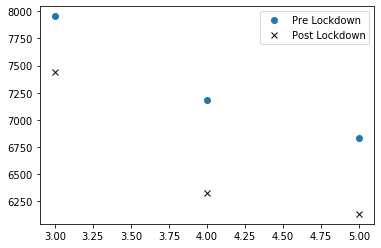

In [198]:
x = power_demand_weekday_AT_preLockdown.groupby([
    power_demand_weekday_AT_preLockdown.index.month]).mean()
print(x.head())
#x_unstacked = x.unstack()

y = power_demand_weekday_AT_postLockdown.groupby([
    power_demand_weekday_AT_postLockdown.index.month]).mean()
#y_unstacked = y.unstack()

plt.plot(x["TotalLoadValue"],"o",label="Pre Lockdown")
plt.plot(y["TotalLoadValue"],"x",color="black", label="Post Lockdown")
plt.legend()

                     Year  Month        Day  TotalLoadValue
DateTime DateTime                                          
2015     3         2015.0    3.0  15.954545     7690.566856
         4         2015.0    4.0  15.681818     7044.813447
         5         2015.0    5.0  15.761905     6352.739087
2016     3         2016.0    3.0  16.000000     7891.807428
         4         2016.0    4.0  15.761905     7270.334722


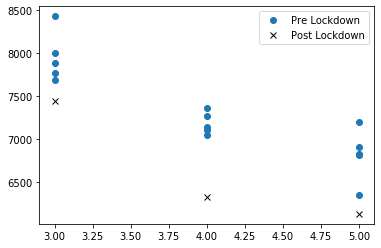

In [240]:
x = power_demand_weekday_AT_preLockdown.groupby([
    power_demand_weekday_AT_preLockdown.index.year,
    power_demand_weekday_AT_preLockdown.index.month]).mean()
print(x.head())

y = power_demand_weekday_AT_postLockdown.groupby([
    power_demand_weekday_AT_postLockdown.index.year,
    power_demand_weekday_AT_postLockdown.index.month]).mean()


plt.plot(x["Month"],x["TotalLoadValue"],"o",label="Pre Lockdown")
plt.plot(y["Month"],y["TotalLoadValue"],"x",color="black", label="Post Lockdown")
plt.legend()

#### The t test revealed that the means of the power demand on weekdays in the months of the lockdown have been statistically different during lockdown compared to pre lockdown. The above graph shows that monthly means (only considering the weekdays until Friday) are lower

## Exercise 5

Download ERA5 temperature data for the next lecture.

First install necessary dependencies `xarray` and `cdsapi`:

In [ ]:
import sys
!conda install --yes --prefix {sys.prefix} xarray
!conda install --yes --prefix {sys.prefix} -c conda-forge cdsapi

#conda install --yes xarray
#conda install --yes -c conda-forge cdsapi

In [25]:
conda config --add channels conda-forge


Note: you may need to restart the kernel to use updated packages.


In [26]:
import sys
!conda install --yes --prefix {sys.prefix} cdsapi

Solving environment: ...working... done

# All requested packages already installed.



The [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/) provides [reanalysis climate data](https://cds.climate.copernicus.eu/cdsapp#!/search?type=dataset&keywords=((%20%22Product%20type:%20Reanalysis%22%20))). We are going to download [ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land?tab=form) data and use the [temperature 2m above ground values](https://apps.ecmwf.int/codes/grib/param-db?id=167).

Register for the CDS API and install the API key by following [this guide](https://cds.climate.copernicus.eu/api-how-to). You don't need to run `pip install cdsapi`, this has been done in the cell above already using conda.

In [28]:
import cdsapi

c = cdsapi.Client()

In [30]:
# Add the path to the lecture repository here:
PATH_TO_LECTURE_REPO =  '../..'

if not os.path.isdir(Path(PATH_TO_LECTURE_REPO) / 'lecture00-introduction'):
    raise RuntimeError(f"Wrong path to lecture repository: PATH_TO_LECTURE_REPO = {PATH_TO_LECTURE_REPO}")

We'll download data from 2015 to 2020 in a bounding box which covers all countries we used so far for our analysis.
To make the download a bit faster, we'll use a [0.5° grid](https://confluence.ecmwf.int/display/CKB/ERA5%3A+Web+API+to+CDS+API) instead of the 0.1° grid. This will download approximately 500MB. The download might take a couple of hours, because the data is prepared on their servers before it can be downloaded.

In [ ]:
filename = Path(PATH_TO_LECTURE_REPO) / 'data' / 'temperatures_era5.nc'

north, west, south, east = 70.,-13.5, 35.5, 24.5

c.retrieve(
    'reanalysis-era5-land',
    {
        'format': 'netcdf',
        'variable': '2m_temperature',
        'area': [
            north, west, south, east
        ],
        'grid': [0.5, 0.5],  # grid in 0.5deg steps in longitude/latitude
        'day': [f"{day:02d}" for day in range(1, 32)],
        'time': [f"{hour:02d}:00" for hour in range(24)],
        'month': [f"{month:02d}" for month in range(1, 13)],
        'year': [str(year) for year in range(2015, 2021)],
    },
    f"{filename}.part")

# this prevents you from accidentally using broken files:
os.rename(f"{filename}.part", filename)

## Exercise 6

Load the file downloaded in exercise 3 and plot the temperature for one location. This is also a test if the download was successful. To load the file import the library `xarray`. Typically it is imported by using `import xarray as xr`. Then load the file using the command `xr.load_dataset(filename)`. Check the type of the return value. Then select the data variable `t2m` (temperature at 2m), select the values for `longitude=16.5` and `latitude=48` by using `temperatures_dataset.t2m.sel(longitude=16.5, latitude=48.)`. Then plot the result by calling `.plot()` on the resulting object.

Does the result look reasonable?

<class 'xarray.core.dataset.Dataset'>
<xarray.Dataset>
Dimensions:    (latitude: 5, longitude: 5, time: 5)
Coordinates:
  * longitude  (longitude) float32 -13.5 -13.0 -12.5 -12.0 -11.5
  * latitude   (latitude) float32 70.0 69.5 69.0 68.5 68.0
  * time       (time) datetime64[ns] 2015-01-01 ... 2015-01-01T04:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2020-05-28 18:01:29 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...


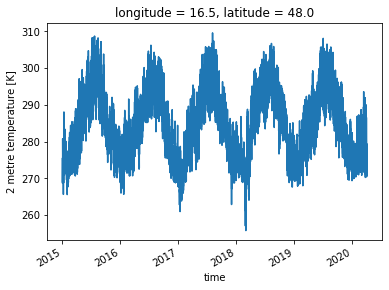

In [42]:
import xarray as xr

file_name = Path(PATH_TO_LECTURE_REPO) / 'data' / 'temperatures_era5.nc'
temp_data = xr.load_dataset(file_name)

print(type(temp_data))
print(temp_data.head())
sel_dat = temp_data.t2m.sel(longitude=16.5, latitude=48.)

sel_dat.plot()